In [140]:
import glob
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [141]:
def tpr(tp, fn):
    if tp == 0 and fn == 0:
        return 0
    return tp / (tp + fn)


def tnr(tn, fp):
    if tn == 0 and fp == 0:
        return 0
    return tn / (tn + fp)


def ppv(tp, fp):
    if tp == 0 and fp == 0:
        return 0
    return tp / (tp + fp)


def fpr(fp, tn):
    if fp == 0 and fp == 0:
        return 0
    return fp / (fp + tn)


def balanced_acc(tpr, tnr):
    return (tpr + tnr) / 2


def f1(ppv, tpr):
    if ppv == 0 and tpr == 0:
        return 0
    return 2 * ppv * tpr / (ppv + tpr)


In [142]:
folds = glob.glob("folds/*")

for i, fold in enumerate(folds):
    with open(fold, "rb") as f:
        fold_dict = pkl.load(f)

    y_test = fold_dict["y_test"]

    if i == 0:
        global_target = y_test

    else:
        global_target = np.vstack((global_target,y_test))

global_target.shape

(38331, 1)

In [143]:
from sklearn.metrics import auc

results_list = glob.glob("grid_results/*")

print("numero de redes treinadas: ", len(results_list))

metrics_dict = {}
auc_list = {"index": [], "auc": []}

FPR_list = TPR_list = []

for i, file in enumerate(results_list):
    with open(file, "rb") as handle:
        result = pkl.load(handle)["y_predict"]

    metrics_dict[i] = {
        "file_name": 0,
        "th": [],
        "tpr": [],
        "fpr": [],
        "tnr": [],
        "ppv": [],
        "bacc": [],
        "f1": [],
        "auc": 0,
    }

    metrics_dict[i]["file_name"] = file.split("/")[-1]

    threshold_eval = np.linspace(min(result), max(result), num=50)

    for thres in threshold_eval:
        predictions = np.zeros(result.shape)

        predictions[result < thres] = 1

        # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
        TP = np.sum(np.logical_and(predictions == 1, global_target == 1))

        # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
        TN = np.sum(np.logical_and(predictions == 0, global_target == 0))

        # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
        FP = np.sum(np.logical_and(predictions == 1, global_target == 0))

        # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
        FN = np.sum(np.logical_and(predictions == 0, global_target == 1))

        TPR = tpr(TP, FN)

        FPR = fpr(FP, TN)

        TNR = tnr(TN, FP)

        PPV = ppv(TP, FP)

        BACC = balanced_acc(TPR, TNR)

        F1 = f1(PPV, TPR)

        metrics_dict[i]["tpr"].append(TPR)
        metrics_dict[i]["fpr"].append(FPR)
        metrics_dict[i]["tnr"].append(TNR)
        metrics_dict[i]["ppv"].append(PPV)
        metrics_dict[i]["bacc"].append(BACC)
        metrics_dict[i]["f1"].append(F1)
        metrics_dict[i]["th"].append(thres)

    metrics_dict[i]["auc"] = auc(metrics_dict[i]["fpr"], metrics_dict[i]["tpr"])

    auc_list["index"].append(i)
    auc_list["auc"].append(metrics_dict[i]["auc"])

auc_df = pd.DataFrame(auc_list).sort_values(by=["auc"], ascending=False)

auc_df.head(10)

numero de redes treinadas:  548


,index,auc
350,350,0.999500
227,227,0.999500
498,498,0.999491
351,351,0.999483
535,535,0.999478
167,167,0.999471
104,104,0.999469
368,368,0.999469
5,5,0.999464
260,260,0.999458


layers_(3, 3)__activation_function_sigmoid__output_function_sigmoid__batch_300__iter_10__LearnR_0.0001__Beta1_0.85__Beta2_0.9.pkl
0.999500394408733


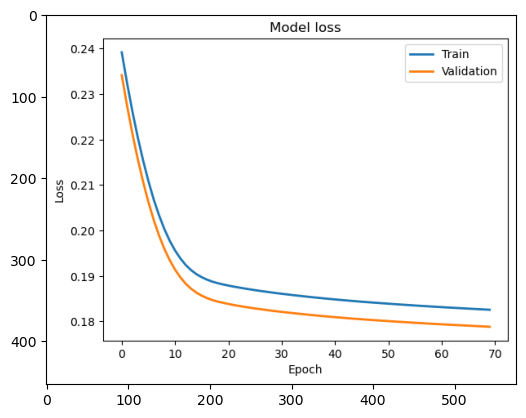

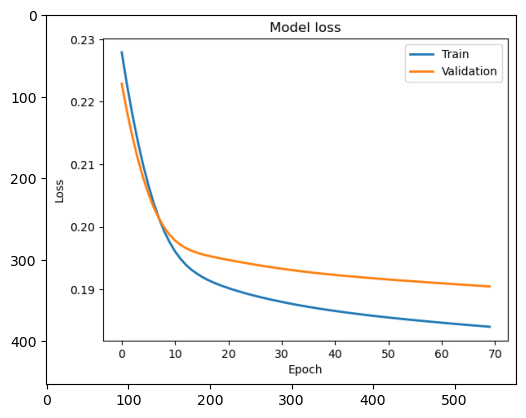

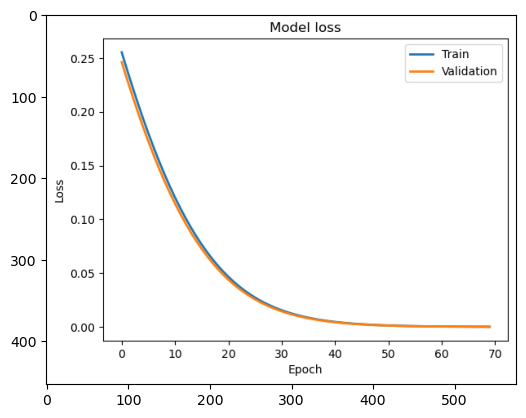

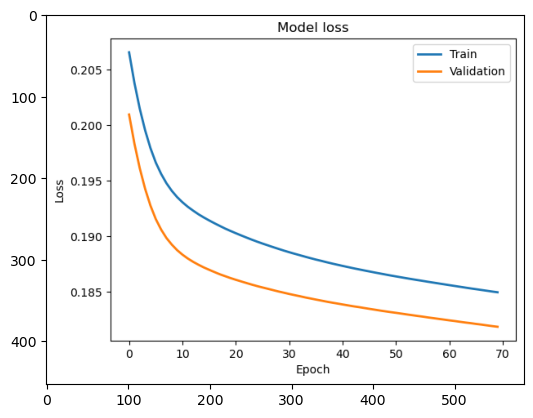

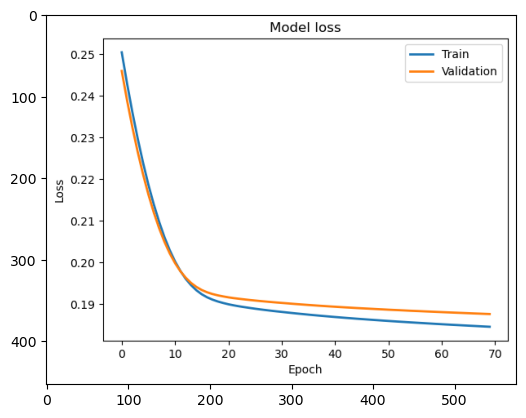

layers_(10, 10)__activation_function_softmax__output_function_sigmoid__batch_400__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl
0.9995003431962418


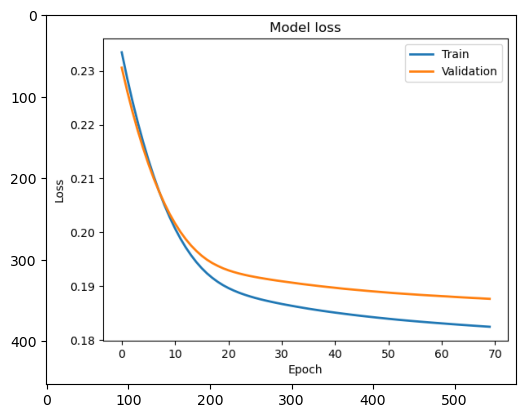

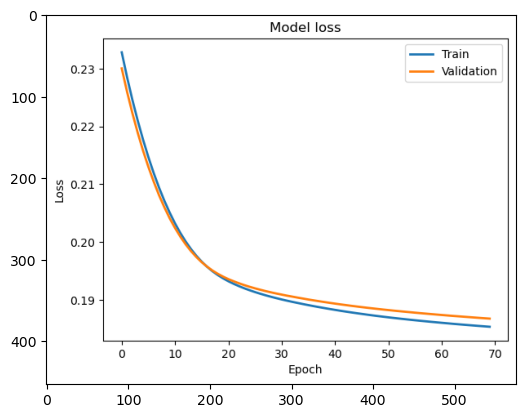

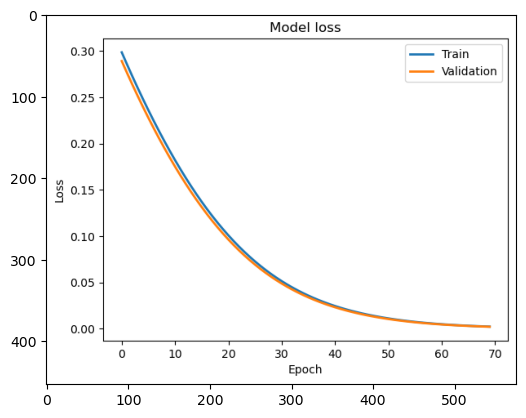

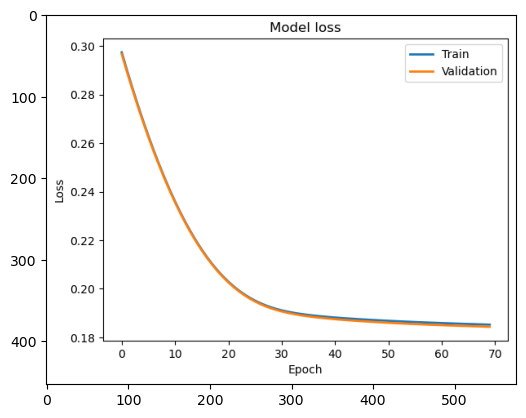

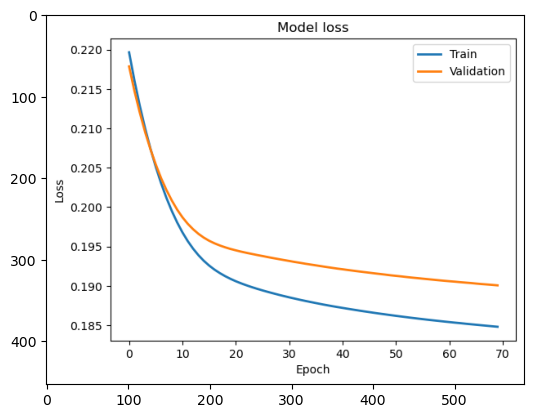

layers_(3, 3)__activation_function_relu__output_function_sigmoid__batch_400__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl
0.9994907984682038


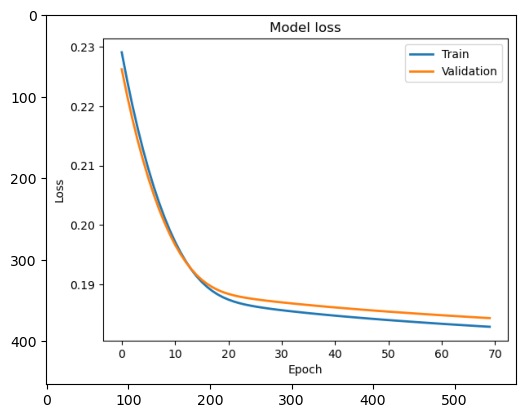

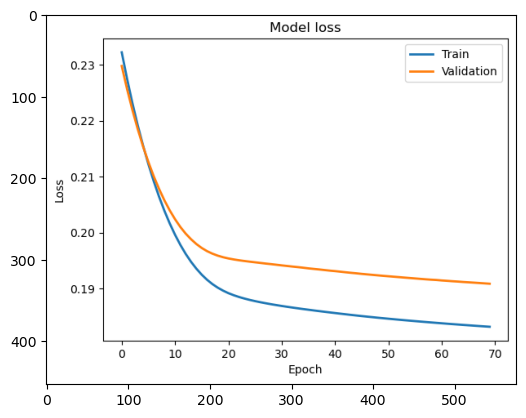

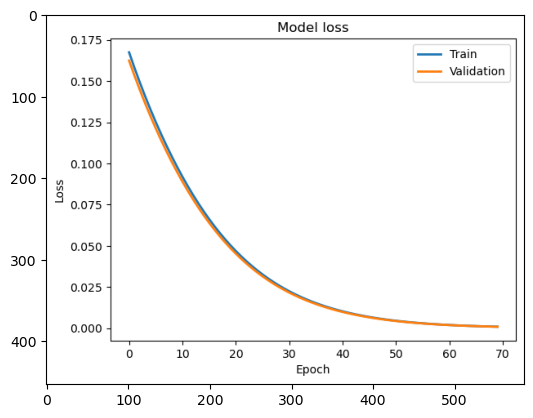

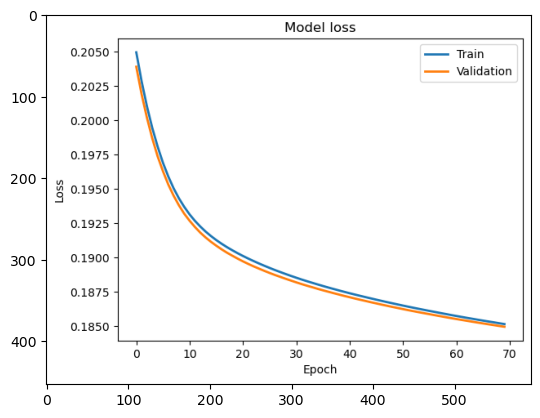

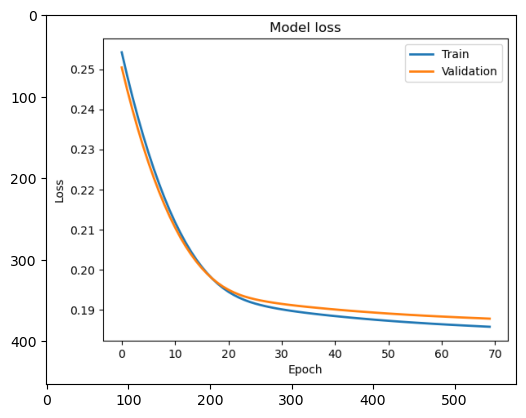

layers_(3, 3, 3)__activation_function_relu__output_function_sigmoid__batch_300__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl
0.9994832446257591


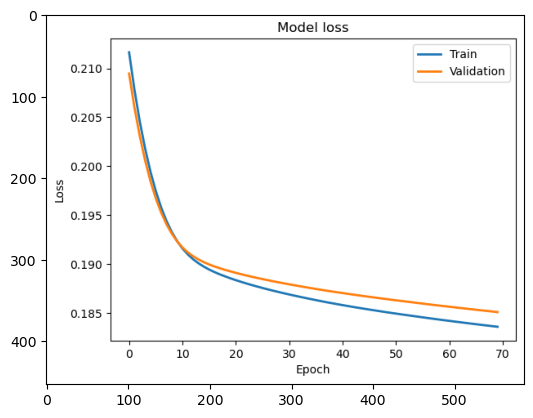

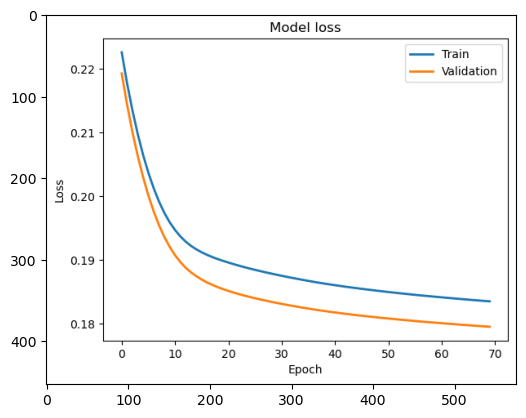

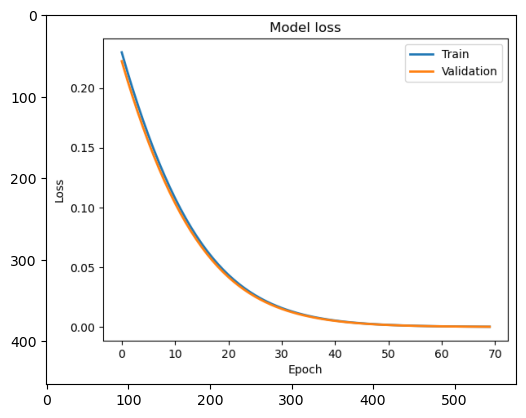

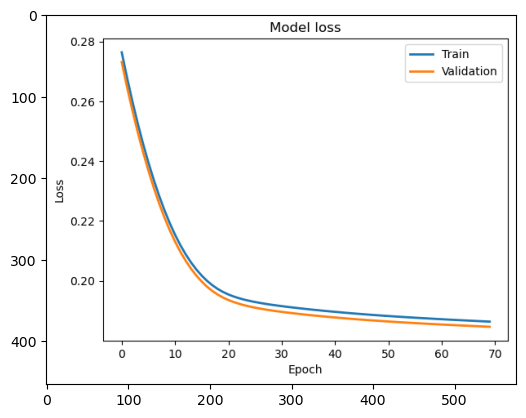

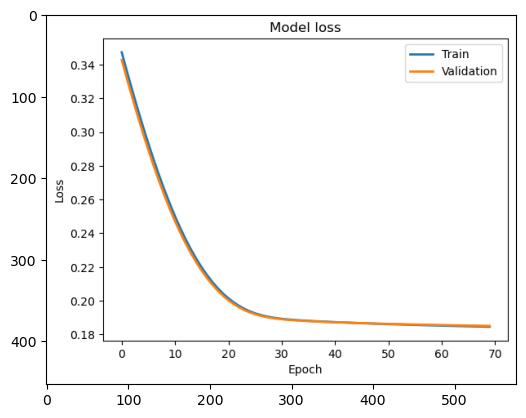

layers_(5, 5)__activation_function_softmax__output_function_sigmoid__batch_400__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl
0.9994775258975807


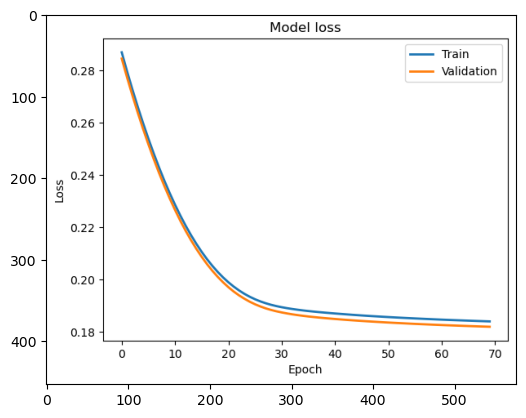

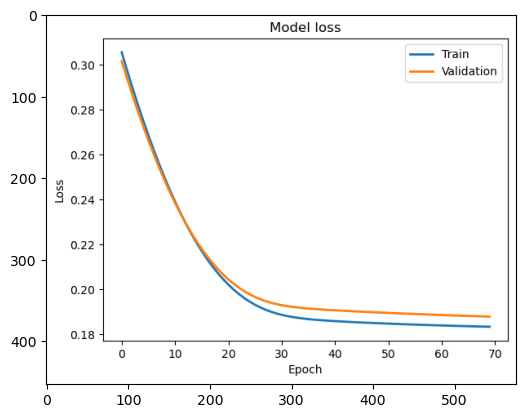

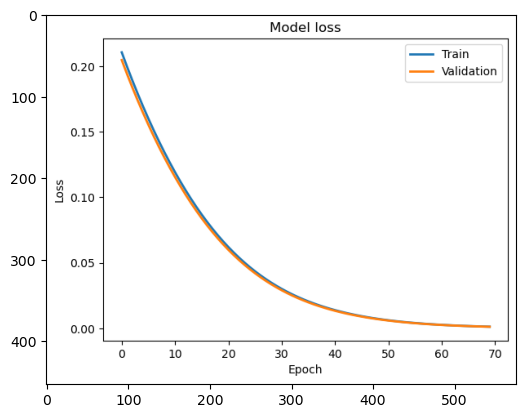

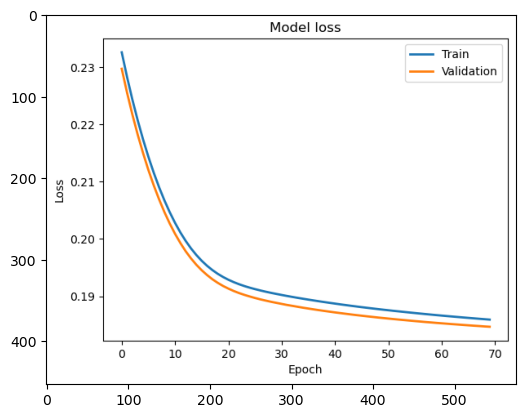

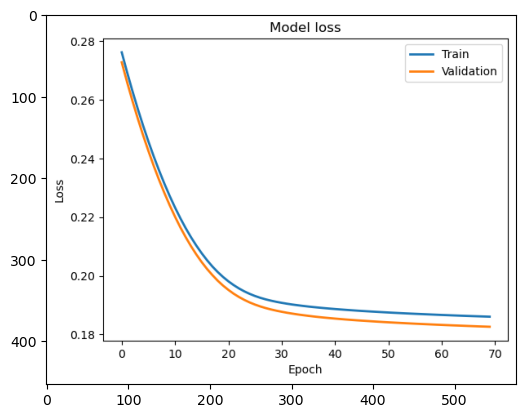

layers_(3, 3)__activation_function_sigmoid__output_function_sigmoid__batch_200__iter_10__LearnR_0.0001__Beta1_0.85__Beta2_0.99.pkl
0.9994708213289476


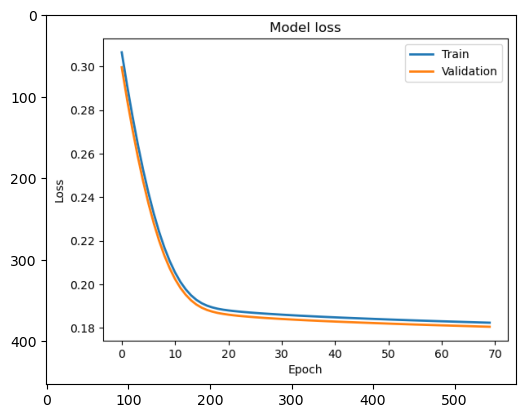

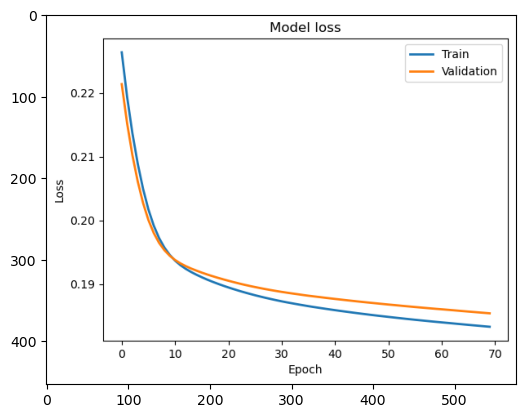

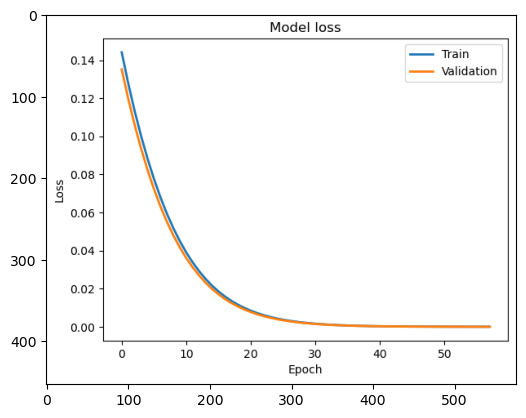

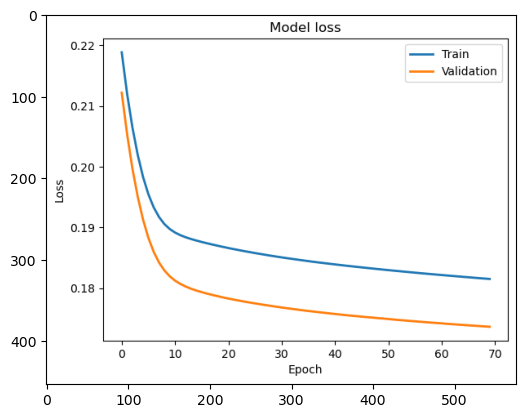

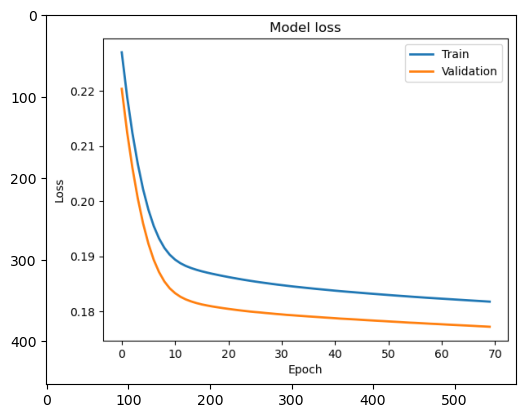

layers_(10, 10)__activation_function_sigmoid__output_function_sigmoid__batch_400__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl
0.9994692358755758


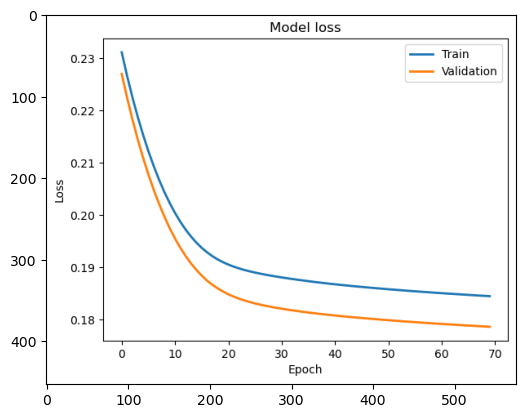

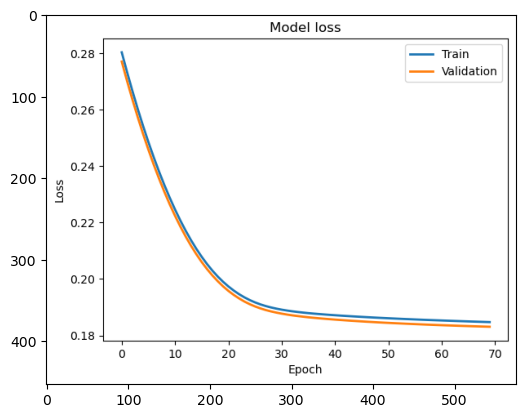

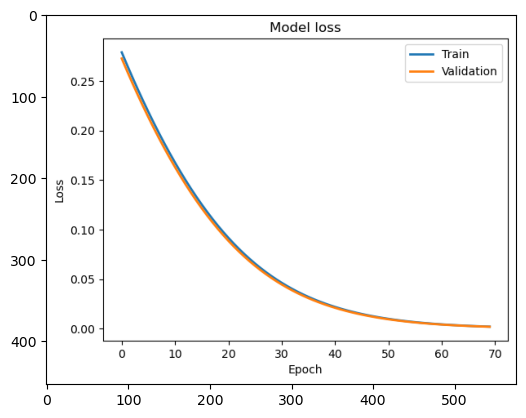

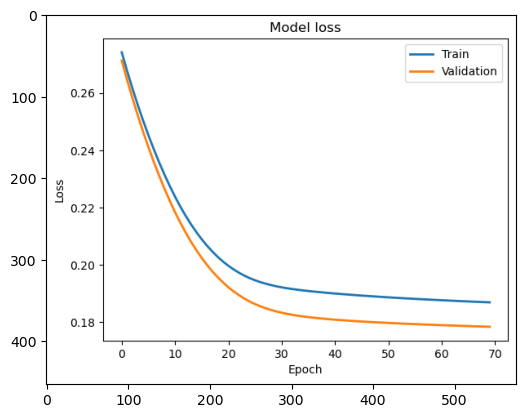

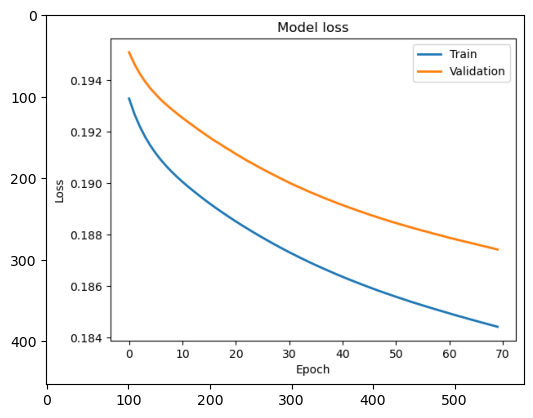

layers_(3, 3)__activation_function_softmax__output_function_sigmoid__batch_400__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl
0.9994691227813245


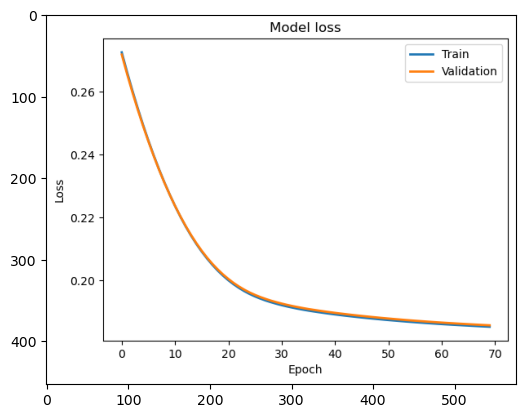

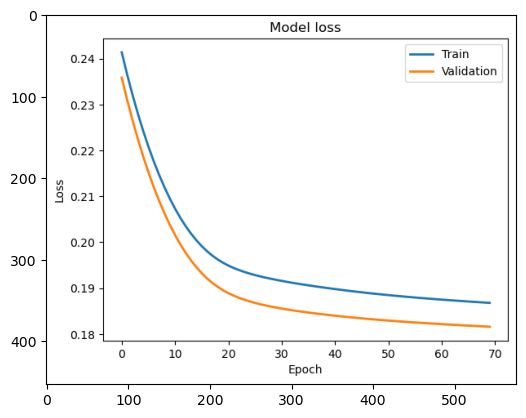

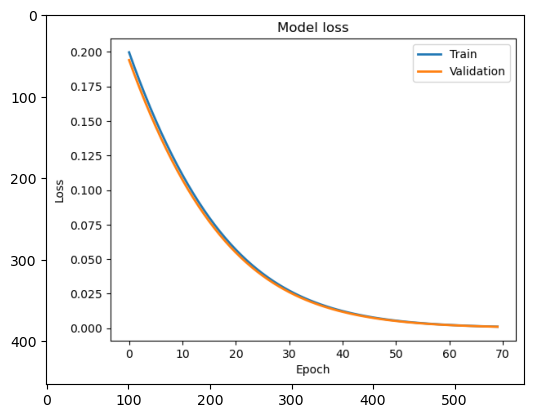

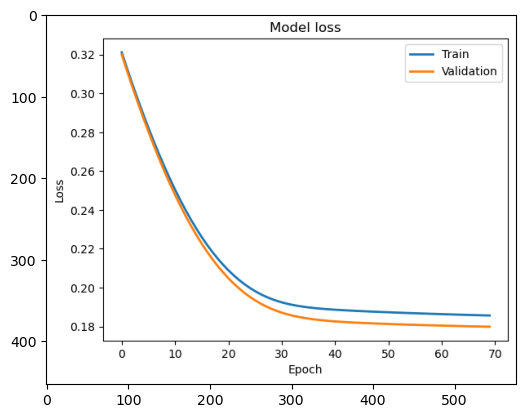

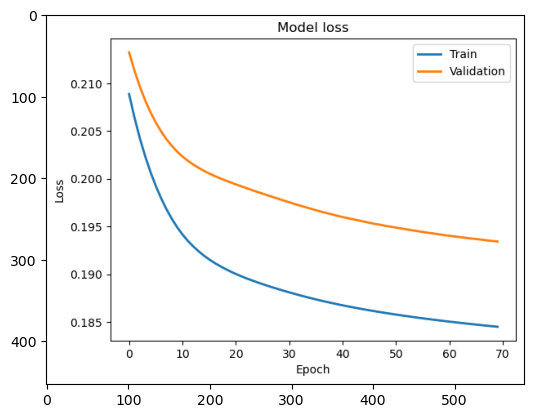

layers_(3, 3)__activation_function_sigmoid__output_function_sigmoid__batch_400__iter_10__LearnR_0.0001__Beta1_0.9__Beta2_0.99.pkl
0.9994644432399457


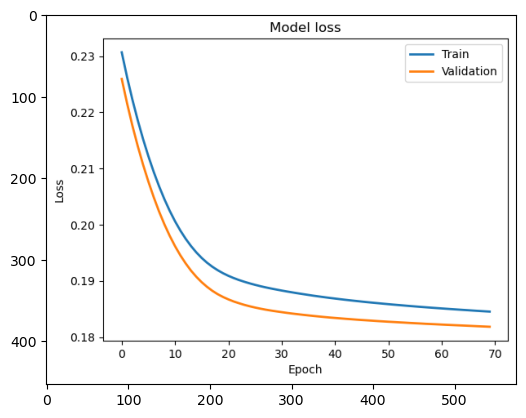

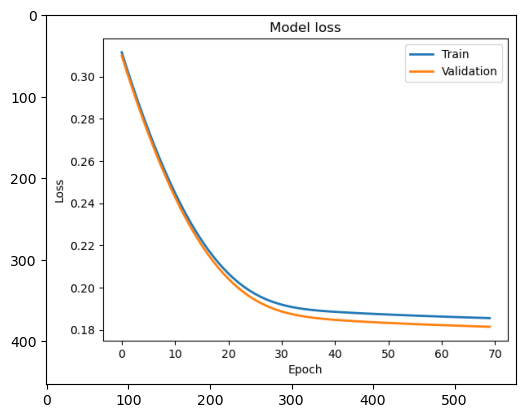

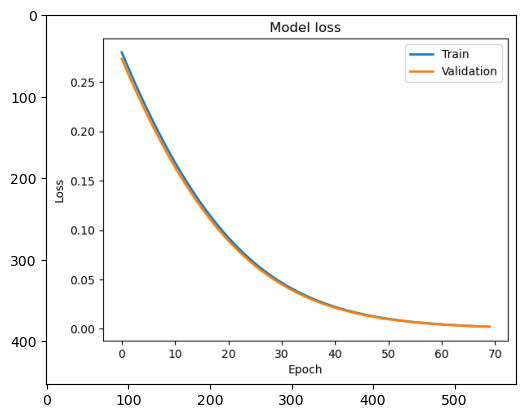

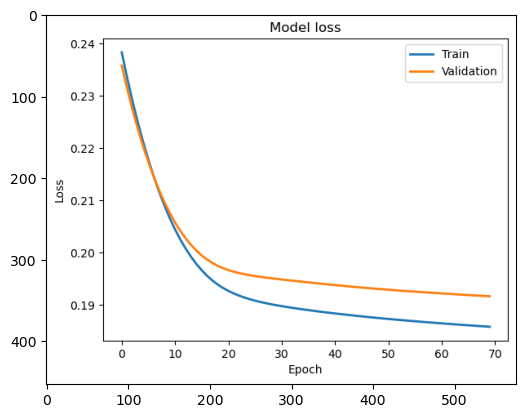

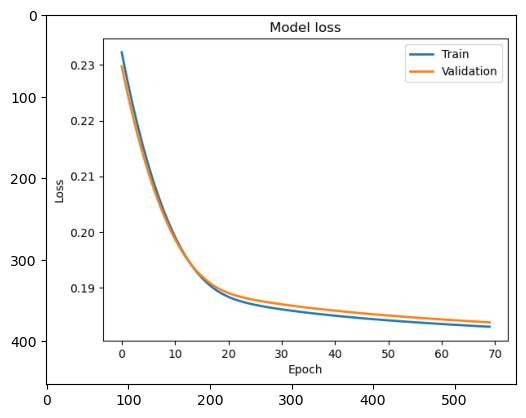

layers_(3, 3)__activation_function_softmax__output_function_sigmoid__batch_400__iter_10__LearnR_0.0001__Beta1_0.99__Beta2_0.99.pkl
0.9994584087014051


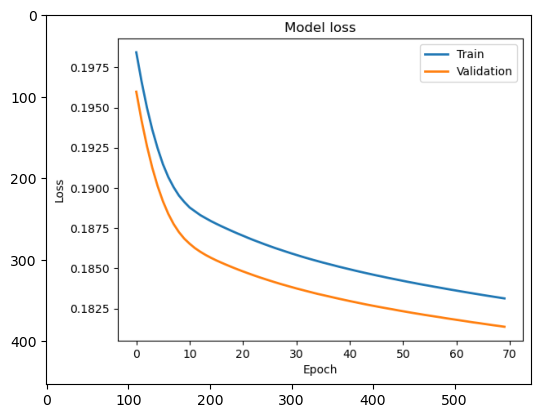

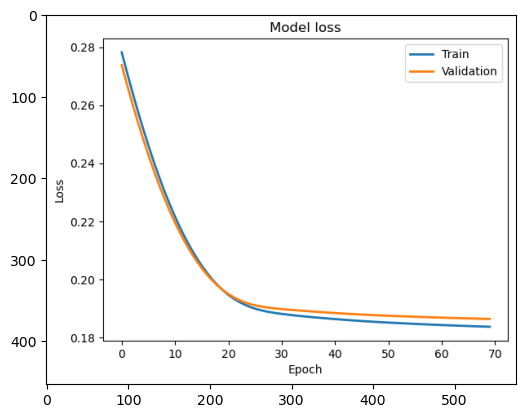

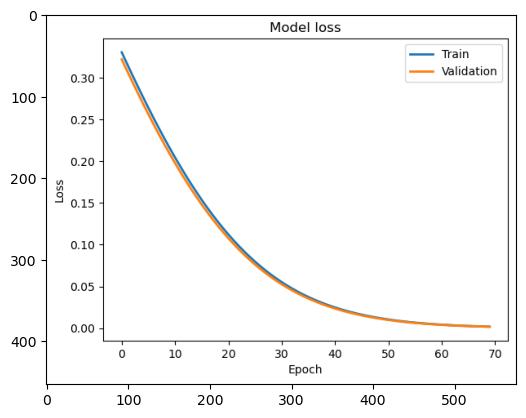

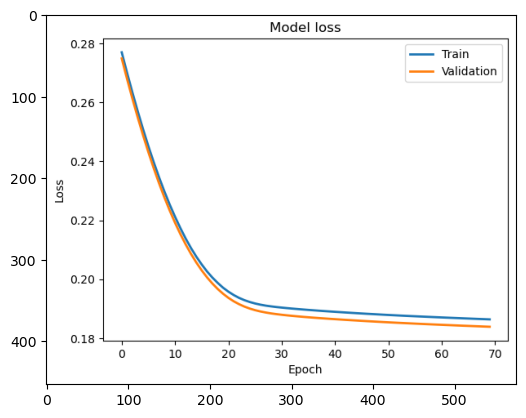

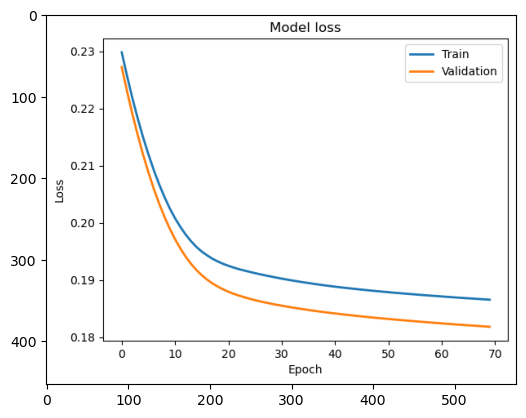

In [144]:
import matplotlib.image as mpimg

for i in range(10):
    index = auc_df.index[i]

    print(metrics_dict[index]["file_name"])
    print(metrics_dict[index]["auc"])
    
    for j in range(5):
        img = mpimg.imread(
            "learning_curves/"
            + "model-loss__"
            + metrics_dict[index]["file_name"]
            + "__fold_{}__.png".format(j)
        )
        imgplot = plt.imshow(img)
        plt.show()

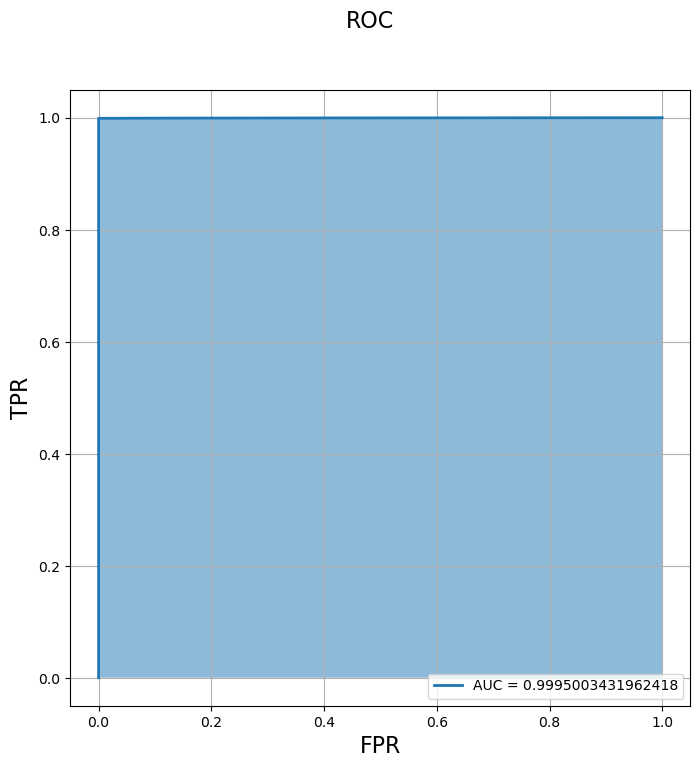

<Figure size 640x480 with 0 Axes>

In [145]:
scale = 1

width = height = 8

choice = 1

index = auc_df.index[choice]

best_nn_df = pd.DataFrame(metrics_dict[index])

fig = plt.figure(figsize=[scale * width, scale * height])
ax = fig.add_subplot(1, 1, 1)
fig.suptitle("ROC", fontsize=16)

ax.plot(
    best_nn_df.fpr,
    best_nn_df.tpr,
    linewidth=2,
    label="AUC = {}".format(best_nn_df.auc.values[0]),
)

ax.fill_between(best_nn_df.fpr, [0 for i in range(len(best_nn_df.fpr))], best_nn_df.tpr, alpha=0.5)

ax.set_ylabel("TPR", fontsize=16)
ax.set_xlabel("FPR", fontsize=16)

ax.legend()
ax.grid()

plt.show()

plt.savefig("figures/ROC.png")

In [146]:
best_nn_df = best_nn_df.sort_values(by=["tpr"],ascending=False)

best_nn_df[best_nn_df.fpr == 0].head(10)

,file_name,th,tpr,fpr,tnr,ppv,bacc,f1,auc
36,"layers_(10, 10)__activation_function_softmax__...",[0.8732444],0.998925,0.0,1.0,1.0,0.999463,0.999462,0.9995
35,"layers_(10, 10)__activation_function_softmax__...",[0.8644024],0.998892,0.0,1.0,1.0,0.999446,0.999446,0.9995
34,"layers_(10, 10)__activation_function_softmax__...",[0.85556054],0.997948,0.0,1.0,1.0,0.998974,0.998973,0.9995
33,"layers_(10, 10)__activation_function_softmax__...",[0.84671855],0.995993,0.0,1.0,1.0,0.997997,0.997993,0.9995
32,"layers_(10, 10)__activation_function_softmax__...",[0.8378766],0.993908,0.0,1.0,1.0,0.996954,0.996945,0.9995
31,"layers_(10, 10)__activation_function_softmax__...",[0.8290347],0.990195,0.0,1.0,1.0,0.995097,0.995073,0.9995
30,"layers_(10, 10)__activation_function_softmax__...",[0.8201927],0.986155,0.0,1.0,1.0,0.993078,0.993029,0.9995
29,"layers_(10, 10)__activation_function_softmax__...",[0.8113508],0.980878,0.0,1.0,1.0,0.990439,0.990347,0.9995
28,"layers_(10, 10)__activation_function_softmax__...",[0.80250883],0.964786,0.0,1.0,1.0,0.982393,0.982077,0.9995
27,"layers_(10, 10)__activation_function_softmax__...",[0.7936669],0.939182,0.0,1.0,1.0,0.969591,0.968637,0.9995
